# Electromobility example

This example shows you the first steps how to integrate electromobility into eDisGo using data from [SimBEV](https://github.com/rl-institut/simbev) and [TracBEV](https://github.com/rl-institut/tracbev). SimBEV provides data on standing times, charging demand, etc. per vehicle, whereas TracBEV provides potential charging point locations.

**Learn more about eDisGo**

* __[eDisGo Source Code](https://github.com/openego/eDisGo)__
* __[eDisGo Documentation](http://edisgo.readthedocs.io/en/dev/)__

## Installation and setup

This notebook requires a working installation of eDisGo as well as additional packages like `jupyter notebook` to run the example and `plotly` to view the grid topology. You can install all of these as follows:

```python
pip install -e .[examples]
```

Checkout the eDisGo documentation on [how to install eDisGo](https://edisgo.readthedocs.io/en/dev/quickstart.html#getting-started) for more information.

### Import packages

In [1]:
import os

import geopandas as gpd
import pandas as pd
import requests
import zipfile

import matplotlib.pyplot as plt

from copy import deepcopy
from pathlib import Path
from bs4 import BeautifulSoup

from edisgo.edisgo import EDisGo
from edisgo.tools.logger import setup_logger
from edisgo.tools.plots import plot_dash, plot_plotly

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/sqlalchemy/ext/declarative/base.py:433: SAWarning:

Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/sqlalchemy/ext/declarative/base.py:433: SAWarning:

Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?



In [2]:
%matplotlib notebook

### Set up logger

In [3]:
# set up logger that streams edisgo logging messages with level info and above 
# and other logging messages with level error and above to stdout
setup_logger(
    loggers=[
        {"name": "root", "file_level": None, "stream_level": "error"},
        {"name": "edisgo", "file_level": None, "stream_level": "info"}
    ]
)

### Download example grid

In [4]:
def download_ding0_example_grid():

    # create directories to save ding0 example grid into
    ding0_example_grid_path = os.path.join(
        os.path.expanduser("~"), ".edisgo", "ding0_test_network"
    )
    os.makedirs(ding0_example_grid_path, exist_ok=True)

    # download files
    filenames = [
        "buses",
        "generators",
        "lines",
        "loads",
        "network",
        "switches",
        "transformers",
        "transformers_hvmv",
    ]

    for file in filenames:
        req = requests.get(
            "https://raw.githubusercontent.com/openego/eDisGo/features/%23261-emob-tests/tests/data/ding0_test_network_2/{}.csv".format(
                file
            )
        )
        filename = os.path.join(ding0_example_grid_path, "{}.csv".format(file))
        with open(filename, "wb") as fout:
            fout.write(req.content)


download_ding0_example_grid()

### Set up edisgo object

In [5]:
ding0_grid = os.path.join(os.path.expanduser("~"), ".edisgo", "ding0_test_network")
edisgo = EDisGo(ding0_grid=ding0_grid)

# set up time series
timeindex = pd.date_range("1/1/2011", periods=24 * 7, freq="H")
edisgo.set_timeindex(timeindex)
edisgo.set_time_series_active_power_predefined(
    fluctuating_generators_ts="oedb",
    dispatchable_generators_ts=pd.DataFrame(data=1, columns=["other"], index=timeindex),
    conventional_loads_ts="demandlib",
)
edisgo.set_time_series_reactive_power_control()

# resample time series to have a temporal resolution of 15 minutes, which is the same 
# as the electromobility time series
edisgo.resample_timeseries()

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1983: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

<IPython.core.display.Javascript object>


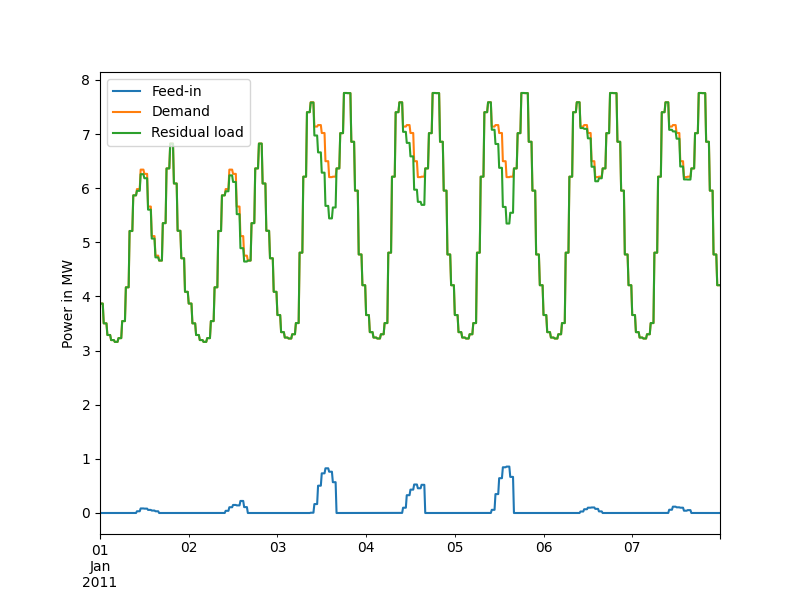

In [6]:
# plot feed-in, demand and residual load

fig, ax = plt.subplots(figsize=(8, 6))

edisgo.timeseries.generators_active_power.sum(axis=1).plot.line(ax=ax)
edisgo.timeseries.loads_active_power.sum(axis=1).plot.line(ax=ax)
edisgo.timeseries.residual_load.plot.line(ax=ax)

ax.legend(["Feed-in", "Demand", "Residual load"])
ax.set_ylabel("Power in MW")

plt.show()

## Prerequisite data

Currently, eDisGo only provides an automated process to obtain electromobility data from [SimBEV](https://github.com/rl-institut/simbev) and [TracBEV](https://github.com/rl-institut/tracbev).

Since SimBEV and TracBEV generate data on municipality level, it is necessary to determine which municipalities lie within or intersect the network area. Therefore, municipality geodata is necessary. The download and how to find the municipalities that intersect the chosen MV grid district is shown in the following.

### Download 'Verwaltungsgebiete' data

In [7]:
vg250_path = Path.home() / ".edisgo" / "vg250"
type(vg250_path)

pathlib.PosixPath

In [8]:
vg250_path = Path(Path.home(), ".edisgo", "vg250")
target = Path(vg250_path, "vg250_01-01.geo84.shape.ebenen/vg250_ebenen_0101/VG250_GEM.shp")

if not target.is_file():
    vg250_path.mkdir(parents=True, exist_ok=True)

    filename = os.path.join(vg250_path, "vg250.geo84")

    url = "https://daten.gdz.bkg.bund.de/produkte/vg/vg250_ebenen_0101/2020/vg250_01-01.geo84.shape.ebenen.zip"
    req = requests.get(url)

    with open(filename, "wb") as fout:
        fout.write(req.content)

    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall(vg250_path)

vg250 = gpd.read_file(target)

vg250.head()

,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,BEM,...,FK_S3,NUTS,ARS_0,AGS_0,WSK,DEBKG_ID,RS,SDV_RS,RS_0,geometry
0,6,4,1,010010000000,01001000,010010000000,Flensburg,Stadt,60,kreisfrei,...,R,DEF01,010010000000,01001000,2008-01-01,DEBKGDL20000E5MA,010010000000,010010000000,010010000000,"POLYGON ((9.41266 54.82264, 9.41318 54.82124, ..."
1,6,4,1,010020000000,01002000,010020000000,Kiel,Stadt,60,kreisfrei,...,R,DEF02,010020000000,01002000,2006-01-01,DEBKGDL20000004J,010020000000,010020000000,010020000000,"POLYGON ((10.16916 54.43138, 10.16957 54.43067..."
2,6,4,1,010030000000,01003000,010030000000,Lübeck,Stadt,60,kreisfrei,...,R,DEF03,010030000000,01003000,2006-02-01,DEBKGDL20000DYMA,010030000000,010030000000,010030000000,"POLYGON ((10.87684 53.98737, 10.87884 53.98595..."
3,6,4,1,010040000000,01004000,010040000000,Neumünster,Stadt,60,kreisfrei,...,R,DEF04,010040000000,01004000,1970-04-26,DEBKGDL20000E4SA,010040000000,010040000000,010040000000,"POLYGON ((9.99545 54.14972, 9.99713 54.14806, ..."
4,6,4,1,010510011011,01051011,010510011011,Brunsbüttel,Stadt,61,--,...,R,DEF05,010510011011,01051011,2009-01-01,DEBKGDL20000E2IK,010510011011,010510011011,010510011011,"POLYGON ((9.16439 53.94509, 9.16706 53.94302, ..."


<IPython.core.display.Javascript object>


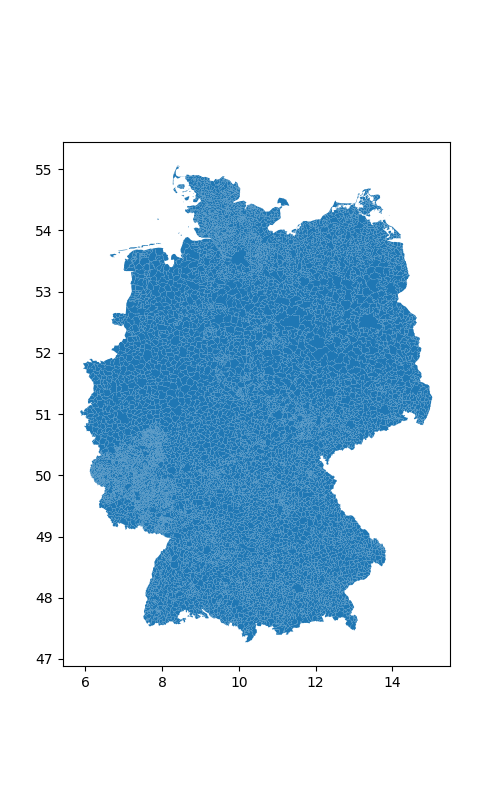

In [9]:
# plot municipality shapes
fig, ax = plt.subplots(figsize=(5, 8))
vg250.plot(ax=ax)
plt.show()

### Check which 'Verwaltungsgebiete' intersect MV grid

In [10]:
mv_grid_gdf = gpd.GeoDataFrame(
    pd.DataFrame(data=edisgo.topology.grid_district["geom"], columns=["geometry"]),
    crs=f"EPSG:{edisgo.topology.grid_district['srid']}",
)

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/frame.py:710: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/frame.py:710: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



In [11]:
intersect_gdf = mv_grid_gdf.sjoin(vg250)
print("Intersecting AGS")
intersect_gdf.AGS.to_list()

Intersecting AGS


['05334028', '05334024', '05358016', '05334032']

<IPython.core.display.Javascript object>


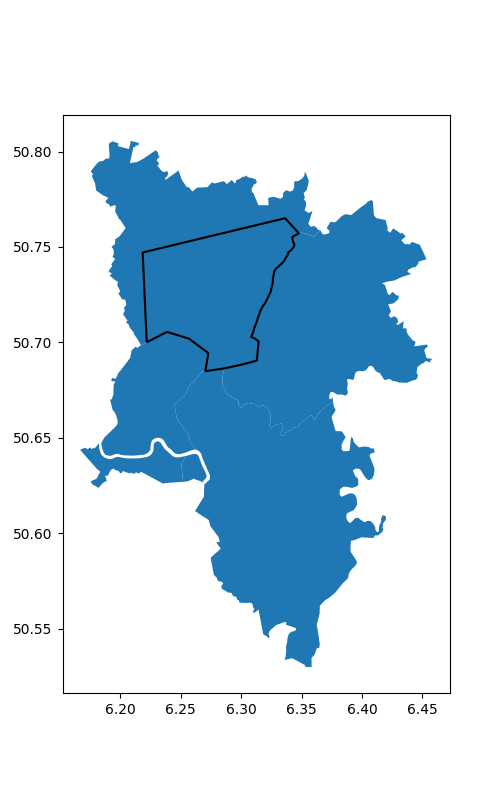

In [12]:
# plot MV grid district (black line) and intersecting AGS (blue shapes)
fig, ax = plt.subplots(figsize=(5, 8))

vg250.loc[vg250.AGS.isin(intersect_gdf.AGS)].plot(ax=ax)
mv_grid_gdf.boundary.plot(ax=ax, color="black")

plt.show()

As most municipalities only intersect the grid district at its border, only the electromobility data for one municipality needs to be generated.

<IPython.core.display.Javascript object>


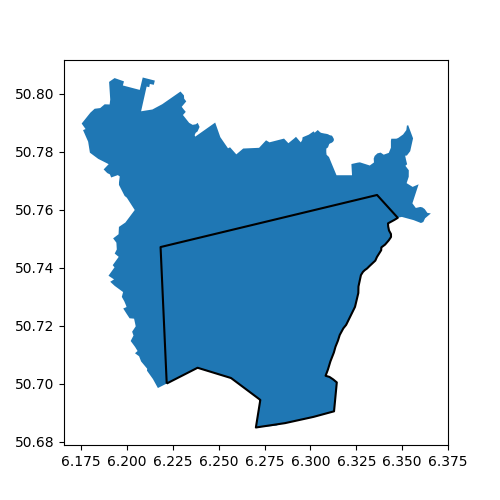

In [13]:
# plot MV grid district (black line) and mainly intersecting AGS (blue shape)
fig, ax = plt.subplots(figsize=(5, 5))

vg250.loc[vg250.AGS == "05334032"].plot(ax=ax)
mv_grid_gdf.boundary.plot(ax=ax, color="black")

plt.show()

## Add electromobility to EDisGo object

### Electromobility data
So far, adding electromobility data to an EDisGo object requires electromobility data from SimBEV (required version: [3083c5a](https://github.com/rl-institut/simbev/commit/86076c936940365587c9fba98a5b774e13083c5a))
and TracBEV (required version: [14d864c](https://github.com/rl-institut/tracbev/commit/03e335655770a377166c05293a966052314d864c)) to be pre-generated. The data is currently not created automatically.



If you don't have SimBEV and TracBEV data yet, you can use the data provided for this example for the ding0 grid downloaded above.

In order to import the electromobility data of the grid that you downloaded above and integrate charging points into the grid, you can use the function `EDisGo.import_electromobility`. Besides loading the electromobility data, the function also allocates the charging demand from SimBEV to charging sites from TracBEV and integrates the charging parks into the grid. This is further explained in the following.

### Allocation of charging demand

After electromobility data is loaded, the charging demand from SimBEV is allocated to potential charging parks from TracBEV. The allocation of the charging processes to the charging infrastructure is carried out with the help of the weighting factor of the potential charging parks determined by TracBEV. This involves a random and weighted selection of one charging park per charging process. In the case of private charging infrastructure, a separate charging point is set up for each EV. All charging processes of the respective EV and charging use case are assigned to this charging point.

For the public charging infrastructure, the allocation is made explicitly per charging process. For each charging process it is determined whether a suitable charging point is already available. For this purpose it is checked whether the charging point is occupied by another EV in the corresponding period and whether it can provide the corresponding charging capacity. If no suitable charging point is available, a charging point is determined randomly and weighted in the same way as for private charging.

### Integration of charging parks

After the allocation of charging demand to specific charging sites, all potential charging parks with charging demand allocated to them are integrated into the grid. This is realised the following way:

* If power rating is <= 0.3 MVA, the charging point is integrated into the LV grid, otherwise it is integrated into the MV grid.
* Integration into LV grid:
    * The considered charging point is integrated into the LV grid whose distribution substation is closest (this is currently done this way because the LV grids are not georeferenced but only the MV grid including the MV-LV substations).
    * If power rating is > 0.1 MVA, the charging point is directly connected to the distribution substation.
    * If power rating is <= 0.1 MVA, the type of connection depends on the charging point use case:
        - Use Case `home`: Charging point is connected to a random household load in the identified LV grid.
        - Use Case `work`: Charging point is connected to a random commercial, industrial or agricultural consumer.
        - Use Case `public`: Charging point is connected to a random grid connection point in the identified LV grid.
* Integration into MV grid:
    * If the power rating of the charging point is > 4.5 MVA, it is directly connected to the HV-MV station.
    * If the power rating of the charging point is <= 4.5 MVA, it is connected to the nearest grid connection point or cable. If a cable is selected, the line is cut at the point closest to the charging station and a new branch tee is added to which the charging station is connected.

In [14]:
# Download simBEV data
url = 'https://github.com/openego/eDisGo/tree/features/%23261-emob-tests/tests/data/simbev_example_scenario/5334032/'
ext = 'csv'

def listFD(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [node.get('href').split("/")[-1] for node in soup.find_all('a') if node.get('href').endswith(ext)]

def download_simbev_example_data():

    # create directories to save ding0 example grid into
    simbev_example_data_path = os.path.join(
        os.path.expanduser("~"), ".edisgo", "simbev_example_data"
    )
    os.makedirs(simbev_example_data_path, exist_ok=True)
    os.makedirs(os.path.join(simbev_example_data_path, "5334032"), exist_ok=True)
    # download files
    filenames = [f for f in listFD(url, ext)]

    for file in filenames:
        req = requests.get(
            "https://raw.githubusercontent.com/openego/eDisGo/features/%23261-emob-tests/tests/data/simbev_example_scenario/5334032/{}".format(
                file
            )
        )
        filename = os.path.join(simbev_example_data_path, "5334032", "{}".format(file))
        with open(filename, "wb") as fout:
            fout.write(req.content)
            
    req = requests.get(
            "https://raw.githubusercontent.com/openego/eDisGo/features/%23261-emob-tests/tests/data/simbev_example_scenario/metadata_simbev_run.json".format(
                file
            )
        )
    filename = os.path.join(simbev_example_data_path, "metadata_simbev_run.json")
    with open(filename, "wb") as fout:
        fout.write(req.content)
        
    return simbev_example_data_path

simbev_example_data_path = download_simbev_example_data()

In [15]:
# Download tracBEV data
url = 'https://github.com/openego/eDisGo/tree/features/%23261-emob-tests/tests/data/tracbev_example_scenario/'
ext = 'gpkg'

def download_tracbev_example_data():

    # create directories to save ding0 example grid into
    tracbev_example_data_path = os.path.join(
        os.path.expanduser("~"), ".edisgo", "tracbev_example_data"
    )
    os.makedirs(tracbev_example_data_path, exist_ok=True)
    
    # download files
    filenames = [f for f in listFD(url, ext)]

    for file in filenames:
        req = requests.get(
            "https://raw.githubusercontent.com/openego/eDisGo/features/%23261-emob-tests/tests/data/tracbev_example_scenario/{}".format(
                file
            )
        )
        filename = os.path.join(tracbev_example_data_path, "{}".format(file))
        with open(filename, "wb") as fout:
            fout.write(req.content)
            
    return tracbev_example_data_path

tracbev_example_data_path = download_tracbev_example_data()

In [16]:
edisgo.import_electromobility(
    simbev_directory=simbev_example_data_path,
    tracbev_directory=tracbev_example_data_path
)

edisgo - INFO: Duplicating potential charging parks to meet the desired grid connections to cars rate of 0.50 %. Iteration: 1.
edisgo - INFO: Duplicating potential charging parks to meet the desired grid connections to cars rate of 25.00 %. Iteration: 1.


/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-pack

### eDisGo electromobility data structure <a class="anchor" id="network"></a>

All data coming from SimBEV and TracBEV is stored in the `Electromobility` object that can be accessed through the `EDisGo` object as follows:

```python
edisgo.electromobility
```

Integrated charging parks can also be found in the `Topology` object:

```python
edisgo.topology.loads_df[edisgo.topology.loads_df.type == "charging_point"]
```

Data stored in the `Electromobility` object is shown in the following.

In [17]:
# SimBEV charging processes data
edisgo.electromobility.charging_processes_df.head()

,ags,car_id,destination,use_case,nominal_charging_capacity_kW,grid_charging_capacity_kW,chargingdemand_kWh,park_time_timesteps,park_start_timesteps,park_end_timesteps,charging_park_id,charging_point_id
0,5334032,1,0_work,work,50.0,55.5556,14.4159,15,218,232,1625,0
1,5334032,1,0_work,work,50.0,55.5556,14.5552,34,319,352,1625,0
2,5334032,1,3_shopping,public,50.0,55.5556,37.5000,3,626,628,1250,144
3,5334032,2,6_home,home,11.0,12.2222,10.3757,88,0,88,947,66
4,5334032,2,6_home,home,11.0,12.2222,10.7987,49,257,305,947,66


In [18]:
# SimBEV configuration data
edisgo.electromobility.simbev_config_df

,eta_cp,stepsize,start_date,end_date,soc_min,grid_timeseries,grid_timeseries_by_usecase,days
0,0.9,15,2011-01-01,2011-01-07,0.2,True,True,7


In [19]:
# TracBEV potential charging point data
edisgo.electromobility.potential_charging_parks_gdf.head()

,user_centric_weight,geometry,ags,use_case
0,1.000000,POINT (6.20975 50.78775),5334032,home
1,0.823529,POINT (6.20823 50.77150),5334032,home
2,0.705882,POINT (6.23117 50.76865),5334032,home
3,0.705882,POINT (6.23266 50.76780),5334032,home
4,0.694118,POINT (6.21535 50.75373),5334032,home


In [20]:
# Charging parks that got integrated into the network
edisgo.electromobility.integrated_charging_parks_df.head()

,edisgo_id
88,Charging_Point_LVGrid_170186_home_1
358,Charging_Point_LVGrid_131067_home_1
566,Charging_Point_LVGrid_179719_home_1
620,Charging_Point_LVGrid_136382_home_1
737,Charging_Point_LVGrid_170180_home_1


In [21]:
edisgo.topology.loads_df[edisgo.topology.loads_df.type == "charging_point"].head()

,bus,p_set,type,annual_consumption,sector,voltage_level,p,mvlv_subst_id,geom
Charging_Point_LVGrid_170186_home_1,Bus_mvgd_2095_lvgd_170186_loa_102,0.0122,charging_point,NaN,home,7,0.0122,170186.0,POINT (6.276213849062917 50.75571589877431)
Charging_Point_LVGrid_131067_home_1,Bus_mvgd_2095_lvgd_131067_loa_106,0.0041,charging_point,NaN,home,7,0.0041,131067.0,POINT (6.221481863057472 50.73053634978644)
Charging_Point_LVGrid_179719_home_1,Bus_mvgd_2095_lvgd_179719_loa_18,0.0122,charging_point,NaN,home,7,0.0122,179719.0,POINT (6.328096635017962 50.763678995461746)
Charging_Point_LVGrid_136382_home_1,Bus_mvgd_2095_lvgd_136382_loa_12,0.0122,charging_point,NaN,home,7,0.0122,136382.0,POINT (6.2577134043525735 50.7209191089763)
Charging_Point_LVGrid_170180_home_1,Bus_mvgd_2095_lvgd_170180_loa_22,0.0041,charging_point,NaN,home,7,0.0041,170180.0,POINT (6.266109373898613 50.74009021249352)


<IPython.core.display.Javascript object>


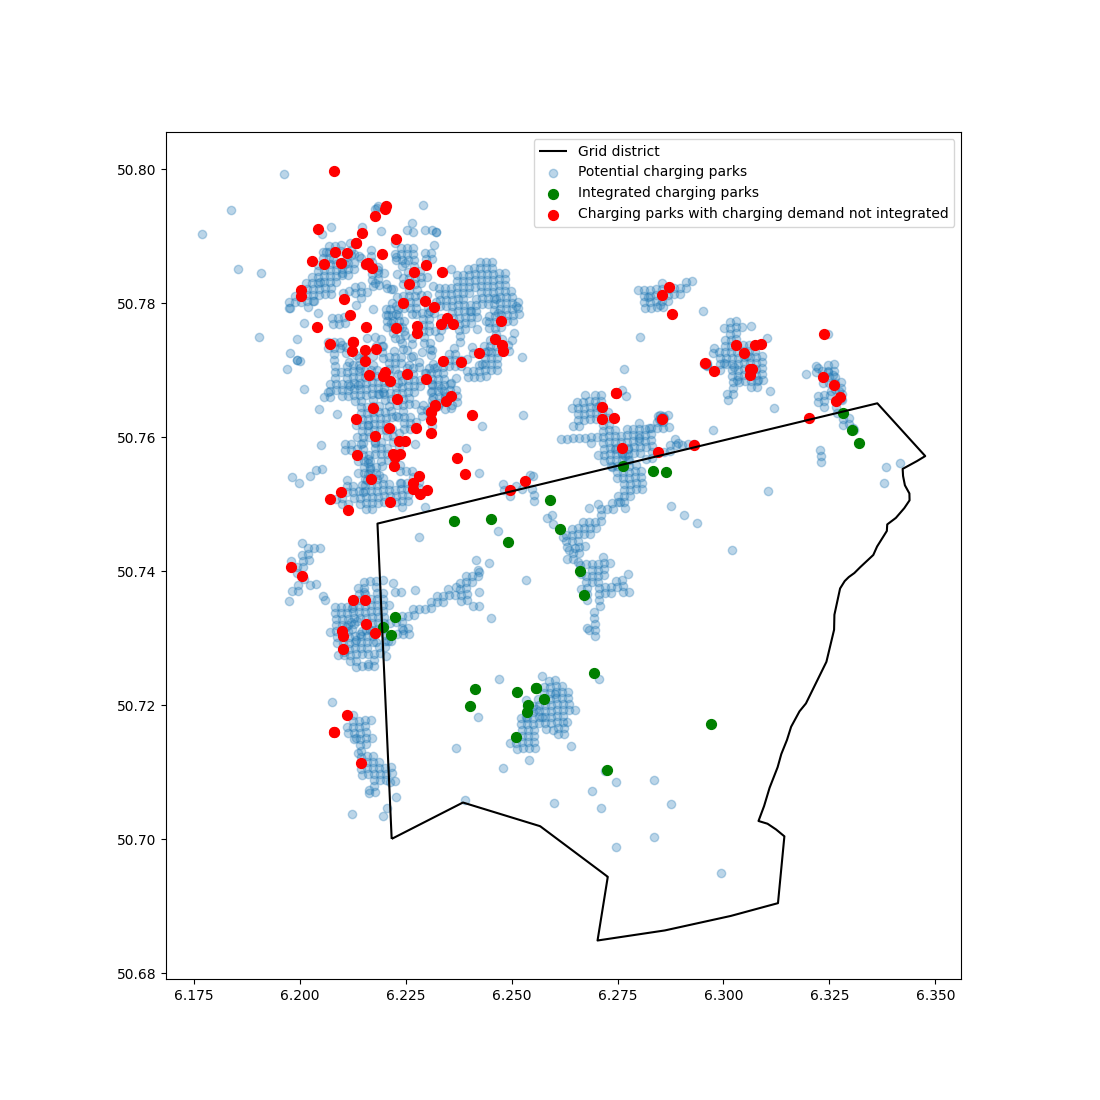

/tmp/ipykernel_42927/2010035007.py:24: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



In [22]:
# plotting the grid district and all potential charging parks

fig, ax = plt.subplots(figsize=(11, 11))

mv_grid_gdf.boundary.plot(ax=ax, color="black")

# plot potential charging parks
edisgo.electromobility.potential_charging_parks_gdf.plot(ax=ax, alpha=0.3)

# plot integrated charging parks
edisgo.electromobility.potential_charging_parks_gdf.loc[
    edisgo.electromobility.integrated_charging_parks_df.index
].plot(ax=ax, color="green", markersize=50)

# plot charging parks with charging demand but outside of the grid district
# and therefore not integrated
charging_parks_with_charging_demand = (
    edisgo.electromobility.charging_processes_df.charging_park_id.unique()
)
charging_parks_not_integrated = set(charging_parks_with_charging_demand) - set(
    edisgo.electromobility.integrated_charging_parks_df.index
)

edisgo.electromobility.potential_charging_parks_gdf.loc[
    charging_parks_not_integrated
].plot(ax=ax, color="red", markersize=50)

ax.legend(
    [
        "Grid district",
        "Potential charging parks",
        "Integrated charging parks",
        "Charging parks with charging demand not integrated",
    ]
)

plt.show()

## Applying different charging strategies

The `EDisGo.import_electromobility()` function does not yield charging time series per charging point but only charging processes taking place at each charging point. The actual charging time series are determined through applying a charging strategy using the function `EDisGo.apply_charging_strategy`.

The eDisGo tool currently offers three different charging strategies: `dumb`, `reduced` and `residual`.
The aim of the charging strategies 'reduced' and 'residual' is to generate the most grid-friendly charging behavior possible without restricting the convenience for end users. Therefore, the boundary condition of all charging strategies is that the charging requirement of each charging process must be fully covered. This means that charging processes can only be flexibilised if the EV can be fully charged while it is stationary. Furthermore, only private
charging processes can be used as a flexibility, since the fulfillment of the service is the priority for public 
charging processes.


* `dumb`: In this charging strategy the cars are charged directly after arrival with the maximum possible charging capacity.

* `reduced`: This is a preventive charging strategy. The cars are charged directly after arrival with the minimum possible charging power. The minimum possible charging power is determined by the parking time and the parameter `minimum_charging_capacity_factor`.

* `residual`: This is an active charging strategy. The cars are charged when the residual load in the MV grid is lowest (high generation and low consumption). Charging processes with a low flexibility are given priority.

In the following all three charging strategies are applied. To show their differences, three EDisGo objects are used.

In [23]:
# copy edisgo object to have three objects to apply charging strategies on
edisgo2 = deepcopy(edisgo)
edisgo3 = deepcopy(edisgo)

In [24]:
# apply default charging strategy "dumb"
edisgo.apply_charging_strategy()

In [25]:
# conduct grid analysis
# to keep the calculation time low in this example, only worst-case timesteps are analysed
residual_load = edisgo.timeseries.residual_load
worst_case_time_steps = pd.DatetimeIndex(
    [residual_load.idxmin(), residual_load.idxmax()]
)
edisgo.analyze(timesteps=worst_case_time_steps);

To change the charging strategy from the default `dumb` to one of the other strategies, the `strategy` parameter has to be set accordingly:

In [26]:
edisgo2.apply_charging_strategy(strategy="reduced")
edisgo2.analyze(timesteps=worst_case_time_steps);

In [27]:
edisgo3.apply_charging_strategy(strategy="residual")
edisgo3.analyze(timesteps=worst_case_time_steps);

**Plot charging time series for differenct charging strategies**

<IPython.core.display.Javascript object>


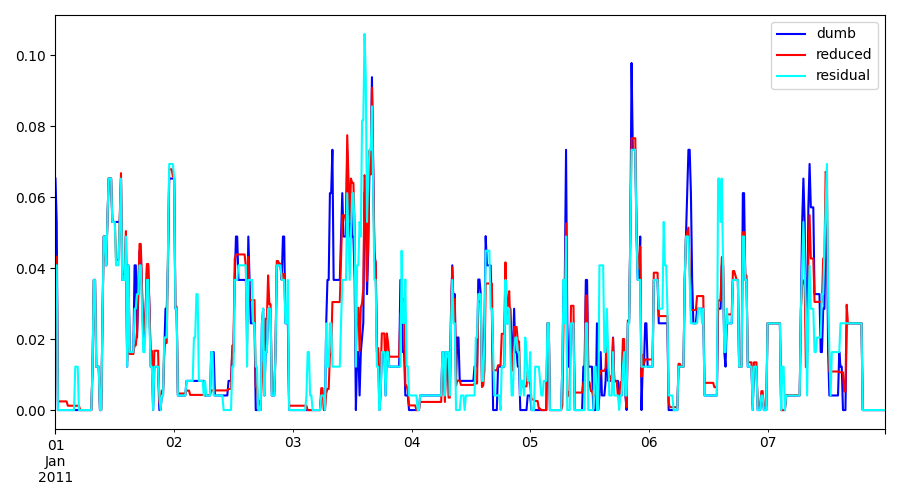

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

edisgo.timeseries.charging_points_active_power(edisgo).sum(axis=1).plot.line(
    ax=ax, color="blue", legend=True, label="dumb"
)
edisgo2.timeseries.charging_points_active_power(edisgo2).sum(axis=1).plot.line(
    ax=ax, color="red", legend=True, label="reduced"
)
edisgo3.timeseries.charging_points_active_power(edisgo3).sum(axis=1).plot.line(
    ax=ax, color="cyan", legend=True, label="residual"
)

plt.tight_layout()

plt.show()

In [29]:
plot_dash(
    edisgo_objects={
        "edisgo": edisgo,
        "edisgo2": edisgo2,
        "edisgo3": edisgo3,
    }
)